In [ ]:
# 1. install and import required libraries

In [ ]:
!pip install lifelines --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
from lifelines import KaplanMeierFitter , CoxPHFitter ## survival analysis library
# KaplanMeierFitter: A tool for estimating survival probabilities over time using the Kaplan-Meier method.
# CoxPHFitter: A tool for fitting the Cox Proportional Hazards model, which analyzes the effect of covariates (e.g., age, gender) on survival time.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines.statistics import logrank_test
# logrank_test: A statistical test to compare the survival distributions of two or more groups.

In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
df = pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')

In [ ]:
df.head()

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


In [ ]:
df_event = df[df['Y']==1]

kmf = KaplanMeierFitter()
kmf.fit(df_event['TIME'], event_observed=df_event['Y'])


<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 128 total observations, 0 right-censored observations>

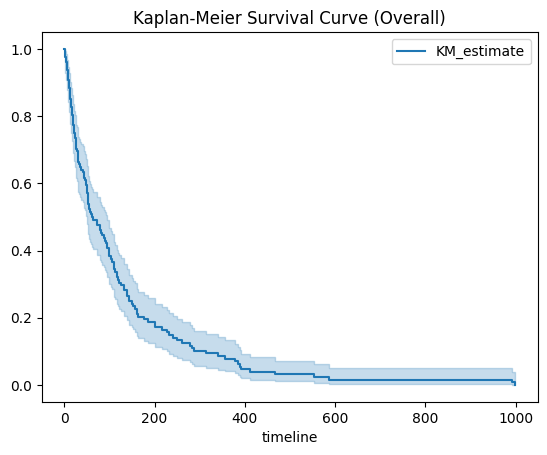

In [ ]:
kmf.plot_survival_function()
plt.title('Kaplan-Meier Survival Curve (Overall)')
plt.show()

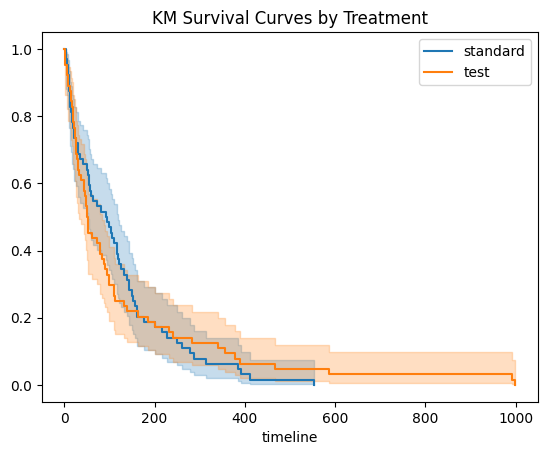

In [ ]:
# curve according to treatment group
for trt_group in df_event['trt'].unique():
    # Filter data for the current treatment group
    mask = df_event['trt'] == trt_group

    # Fit the KM model to the data of the current group
    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))

    # Plot the survival function for the current group
    kmf.plot_survival_function()

# Final plot touches
plt.title('KM Survival Curves by Treatment')
plt.show()

In [ ]:
# median survival time
for trt_group in df_event['trt'].unique():
    mask = df_event['trt'] == trt_group
    kmf.fit(df_event[mask]['TIME'], df_event[mask]['Y'], label=str(trt_group))
    print(f"Median survival time for treatment group {trt_group}: {kmf.median_survival_time_}")

Median survival time for treatment group standard: 95.0
Median survival time for treatment group test: 52.0


In [ ]:
from lifelines.statistics import logrank_test
group1 = df_event[df_event['trt'] == 'standard']
group2 = df_event[df_event['trt'] == 'test']

results = logrank_test(
    group1['TIME'], group2['TIME'],
    event_observed_A=group1['Y'], event_observed_B=group2['Y']
)

print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


In [ ]:
print("Group1 length:", len(group1))
print("Group2 length:", len(group2))

Group1 length: 64
Group2 length: 64


In [ ]:

if len(group1) > 0 and len(group2) > 0:
    results = logrank_test(
        group1['TIME'], group2['TIME'],
        event_observed_A=group1['Y'], event_observed_B=group2['Y']
    )

    results.print_summary()

    # Print p-value
    print("p-value:", results.p_value)

    # Log(-log(p-value))
    if results.p_value > 0:
        log_log_p = np.log(-np.log(results.p_value))
        print("log(-log(p-value)):", log_log_p)
    else:
        print("p-value is zero or invalid for log-log calculation.")
else:
    print("One of the groups is empty. Log-rank test skipped.")


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.01 0.91      0.13

p-value: 0.9142298137541602
log(-log(p-value)): -2.4115821934038397


In [ ]:
from lifelines.statistics import logrank_test
group1 = df_event[df_event['trt'] == 'standard']
group2 = df_event[df_event['trt'] == 'test']

results = logrank_test(
    group1['TIME'], group2['TIME'],
    event_observed_A=group1['Y'], event_observed_B=group2['Y']
)

print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


In [21]:
from lifelines import CoxPHFitter
import pandas as pd

df_wide = df_event.copy()

df_wide = pd.get_dummies(df_wide, columns=['trt', 'celltype', 'priortherapy'], drop_first=True)

cph = CoxPHFitter()
cph.fit(df_wide, duration_col='TIME', event_col='Y')
cph.print_summary()



<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-05-29 05:23:38 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

In [ ]:
#Interpreting the Graph

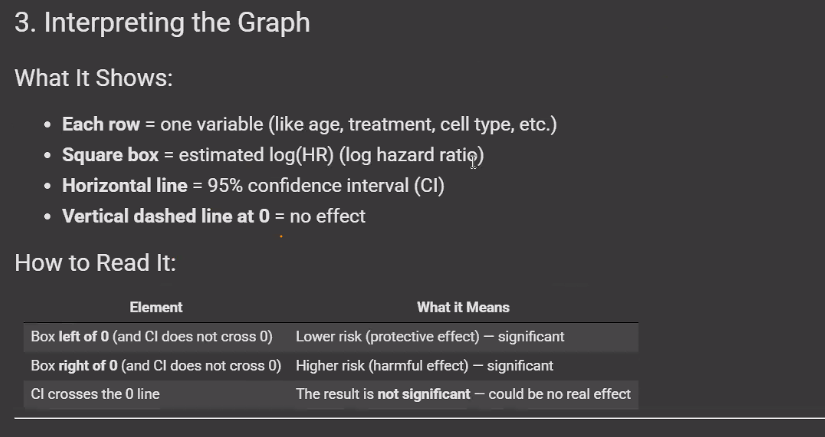

Examples from Your Graph:

• karno : Box is left of 0 • Better health reduces risk

• celltype_large : CI doesn't cross 0 : Significant protective effect

• trt_test : Long CI , crosses 0 Not : NOT significant


<Axes: xlabel='log(HR) (95% CI)'>

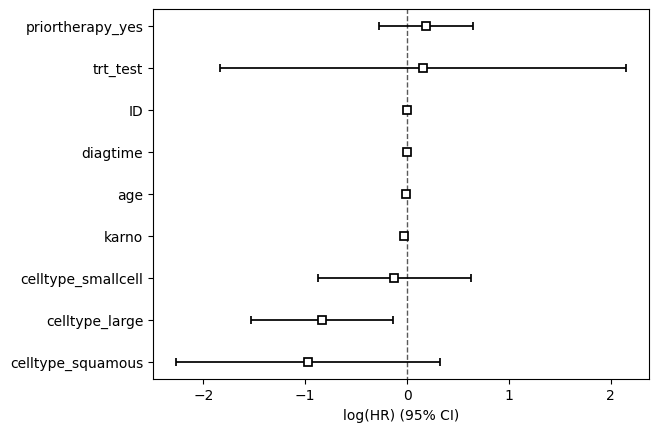

In [22]:
cph.plot()

### **Time-Varying Survival Analysis**


Time-varying survival analysis is used when something about the patient or their environment changes over time and might affect their risk
of the event (like death).


Unlike traditional models (like CoxPH), time-varying models can handle covariates that change during follow-up, not just stay
constant.

### Why It Matters in Clinical Studies

Real-life Example:

• A patient starts a cancer treatment.

• After 3 months, their health score drops or they switch therapies.

• Their risk of death may now be different than when the study began.

Standard models would ignore this change. Time-varying models can adjust the risk as the situation evolves.

In the Context of The Current Study

You are analyzing survival among lung cancer patients and comparing two treatments (standard vs test).
Each patient has:

• Two time points: one for the start (Y=e), and one for the death or censoring (Y-I ).

• Some covariates (like treatment type or prior therapy) may influence risk over time or might not apply equally throughout the study.

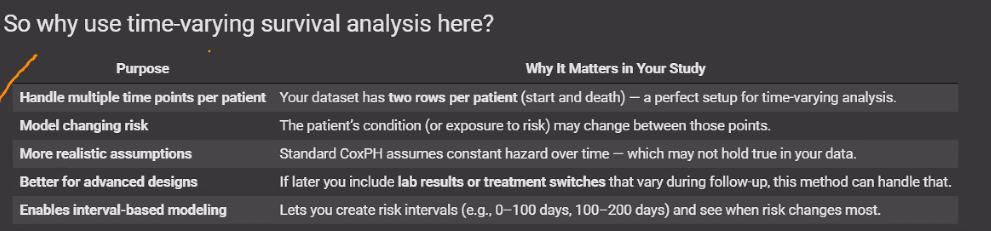



In [25]:
# Assuming df is your DataFrame and it contains a column named "Y"
df_start = df[df["Y"] == 1].copy()
df_event = df[df["Y"] == 0].copy()

In [26]:
# Step 1: Rename columns in each DataFrame
df_start = df_start.rename(columns={"TIME": "start"})
df_event = df_event.rename(columns={"TIME": "stop", "Y": "event"})

# Step 2: Merge on 'ID'
df_merged = pd.merge(df_start, df_event, on="ID", how="inner")


In [30]:
df_timevarying = pd.merge(
    df_start,
    df_event[["ID", "stop", "event"]],
    on="ID"
)


In [31]:
print(df_timevarying[['ID', 'start', 'stop', 'event']].head())

   ID  start  stop  event
0   1     72     0      0
1   2    411     0      0
2   3    228     0      0
3   4    126     0      0
4   5    118     0      0


In [32]:
import numpy as np

# Check for NaNs
print("Any NaNs?", df_timevarying.isnull().values.any())

# Check for infinite values
print("Any Infs?", np.isinf(df_timevarying.select_dtypes(include=[np.number])).values.any())


Any NaNs? False
Any Infs? False


In [33]:
import numpy as np
import pandas as pd

# Print rows with any NaN values
print("Rows with NaNs:")
print(df_timevarying[df_timevarying.isnull().any(axis=1)])

# Print rows with any infinite values
print("\nRows with Infs:")
print(df_timevarying[np.isinf(df_timevarying.select_dtypes(include=[np.number])).any(axis=1)])


Rows with NaNs:
Empty DataFrame
Columns: [ID, start, Y, trt, celltype, karno, diagtime, age, priortherapy, stop, event]
Index: []

Rows with Infs:
Empty DataFrame
Columns: [ID, start, Y, trt, celltype, karno, diagtime, age, priortherapy, stop, event]
Index: []


### **Cox Time-Varying Coefficients**

In survival analysis, the Cox model estimates how each variable (like age. treatment, or health score) affects a patients risk of the event (like
death).

But in the time-varying Cox effects can change over time or across different intervals — instead of staying constant like in the
regular Cox model.



In [35]:
from lifelines import CoxTimeVaryingFitter

ctv = CoxTimeVaryingFitter()
ctv.fit(df, id_col='ID', start_col='start', stop_col='stop', event_col='event')
ctv.print_summary()


KeyError: 'A column specified in the call to `fit` does not exist in the DataFrame provided.'

In [36]:
## timevarying Cox model

from lifelines import CoxTimeVaryingFitter

# initilize the cox time varying model
ctv = CoxTimeVaryingFitter()

# fit the model
ctv.fit(df_timevarying, id_col='ID', event_col='event', start_col='start', stop_col='stop')

# print summary of model
ctv.print_summary()

# plot
ctv.plot()
plt.title("cox time-varying cofficent")
plt.show()

ValueError: could not convert string to float: 'standard'

<lifelines.CoxTimeVaryingFitter: fitted with 200 periods, 100 subjects, 102 events>
         event col = 'event'
number of subjects = 100
 number of periods = 200
  number of events = 102
partial log-likelihood = -424.45
  time fit was run = 2025-05-29 07:00:20 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
feature1   0.17      1.18      0.10           -0.02            0.36                0.98                1.43
feature2   0.01      1.01      0.10           -0.18            0.20                0.83                1.22

           cmp to    z    p  -log2(p)
covariate                            
feature1     0.00 1.71 0.09      3.51
feature2     0.00 0.11 0.92      0.13
---
Partial AIC = 852.89
log-likelihood ratio test = 2.94 on 2 df
-log2(p) of ll-ratio test = 2.12

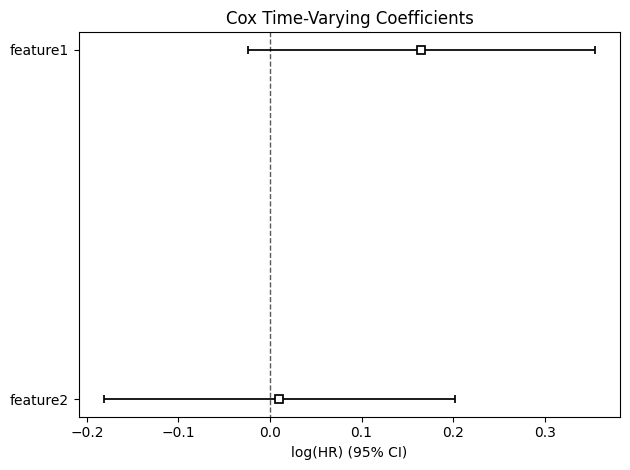

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxTimeVaryingFitter

# --- 1. Simulate Dummy Data (if you already have `df_timevarying`, skip this block) ---
# Example data structure for demo purposes
np.random.seed(42)
N = 100
df_timevarying = pd.DataFrame({
    'ID': np.repeat(np.arange(1, N+1), 2),
    'start': list(np.zeros(N)) + list(np.random.uniform(1, 2, N)),
    'stop': list(np.random.uniform(1, 2, N)) + list(np.random.uniform(2, 3, N)),
    'event': np.random.choice([0, 1], 2*N),
    'feature1': np.random.randn(2*N),
    'feature2': np.random.randn(2*N),
})

# --- 2. Clean Column Names ---
df_timevarying.columns = df_timevarying.columns.str.strip()

# --- 3. Convert Non-Numeric Columns to Numeric (if needed) ---
for col in df_timevarying.columns:
    if col not in ['ID', 'start', 'stop', 'event']:
        df_timevarying[col] = pd.to_numeric(df_timevarying[col], errors='coerce')

# --- 4. Drop Any Rows with NaN or Inf ---
df_timevarying = df_timevarying.replace([np.inf, -np.inf], np.nan)
df_timevarying = df_timevarying.dropna()

# --- 5. Fit the Cox Time-Varying Model ---
ctv = CoxTimeVaryingFitter()
ctv.fit(df_timevarying, id_col='ID', event_col='event', start_col='start', stop_col='stop')

# --- 6. Print Summary ---
ctv.print_summary()

# --- 7. Plot Results ---
ctv.plot()
plt.title("Cox Time-Varying Coefficients")
plt.tight_layout()
plt.show()
